In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
import matplotlib.pyplot as plt

In [62]:
data = pd.read_csv('data/synth_data_for_training.csv')

## Function for metamorphic testing

In [63]:
from onnxruntime.capi.onnxruntime_pybind11_state import InvalidArgument

def test_metamorphic(data, feature_name : str, is_Fraud: bool ,value_from : int, value_to: int, model_path : str):
    data_modified = data.copy() 
    is_checked = 1 if is_Fraud else 0
    test_data= data_modified.loc[data_modified['checked'] == is_checked]
    test_data = test_data.loc[test_data[feature_name] == value_from]
    data_wout = test_data.copy()
    y_wout = data_wout['checked']
    X_wout= data_wout.drop(['checked'], axis=1)
    X_wout = X_wout.astype(np.float32)
    test_data[feature_name] = value_to
    y_test = test_data['checked']
    X_test= test_data.drop(['checked'], axis=1)
    X_test = X_test.astype(np.float32)
    session = rt.InferenceSession(model_path)
        
    try:
        y_pred_onnx1 =  session.run(None, {'X': X_wout.values.astype(np.float32)})
        y_pred_onnx2 =  session.run(None, {'X': X_test.values.astype(np.float32)})
        y_pred_onnx1_np = np.array(y_pred_onnx1[0])
        y_pred_onnx2_np = np.array(y_pred_onnx2[0])
        diff_count = np.sum(y_pred_onnx1_np != y_pred_onnx2_np)
        return diff_count, len(y_pred_onnx1_np)
    except InvalidArgument:
        #print("Got error: empty test dataframe. " "Column is: ", feature_name, " combo is:", is_Fraud, value_from, value_to)
        return 0, 0
    # assert y_pred_onnx1[0].all() == y_pred_onnx2[0].all(), f'Model predictions are different. The model has bias towards {feature_name} with value {value_from} '
    # return True

## Test Cases

In [64]:
test_metamorphic(data, "adres_aantal_brp_adres", True, 11, 11, "model/model_1.onnx")

(0, 0)

In [65]:
test_metamorphic(data, 'persoon_geslacht_vrouw', True, 0, 1, "model/model_1.onnx") #test if changing gender of women who are frauds to men to see if predictions change to not fraud

(16, 663)

In [66]:
test_metamorphic(data, 'persoon_geslacht_vrouw', False, 0, 1, "model/model_1.onnx") #test if changing gender of men who are not frauds to women to see if predictions change to not fraud

(11, 5879)

In [67]:
test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', True, 0, 1, "model/model_1.onnx") #test if changing non dutch speaker people who are frauds to dutch speaking to see if predictions change to not fraud

(21, 708)

In [68]:
test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', False, 1, 0, "model/model_1.onnx") #test if changing dutch speaker people who are not frauds to non-dutch speaking to see if predictions change to fraud

(13, 6558)

In [69]:
test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', True, 2, 1, "model/model_1.onnx") #test if changing people who are frauds and did no take the dutch exam to dutch speaking to see if predictions change to not fraud

(4, 104)

### Making a class that tests all combinations of feature values in metamorphic testing

In [70]:
class MetamorphicTester:
    def __init__(self, data_path, model_path):
        self.model = model_path
        self.df = pd.read_csv(data_path)
        self.mutation_test_results = {}
        self.column_avg = None
        self.global_average = None
        
    def test(self):
        # Iterate over each column in the DataFrame and generate the mutation test combinations
        for column in self.df.columns:
            # Get unique values for the current column
            unique_values = self.df[column].unique()
            if len(unique_values) > 1:
                # We sample two random values from the unique options, and store this in the dictionary
                rand_values = np.random.choice(unique_values, size=2, replace=False)
                combos = []
                for bool in [True, False]:
                    for a in rand_values:
                        for b in rand_values:
                            combos.append([bool, a, b])
                
                self.mutation_test_results[column] = combos
        
        # Go over each combination and get how many tests failed to kill the mutation
        for column, values in self.mutation_test_results.items():
            for combo in values:
                num_differ, length = test_metamorphic(data, column, combo[0], combo[1], combo[2], self.model)
                combo.append(num_differ)
                combo.append(length)
    
    def analyse_test(self):
        # We can now do some basic data analysis.
        # We can compute a score on a per-column basis, getting an average across 8 tests of what percentage of mutants were failed to kill
        # We can also compute a sort of global metric. Just an average across all mutations
        column_avg = []
        all_percentages = []
        
        for column, values in self.mutation_test_results.items():
            percentages = []
            for combo in values:
                # compute percentage, and add it to a temp array to compute the average value
                if combo[4] != 0:
                    res = combo[3]/combo[4]
                    percentages.append(res)
                    all_percentages.append(res)
            column_avg.append((column, np.mean(np.array(percentages))))
        
        column_avg = sorted(column_avg, key=lambda x: x[1], reverse=True)
        
        # Save the results
        self.column_avg = column_avg
        self.global_average = np.mean(np.array(all_percentages)) * 100

# features_to_ignore = ["adres_dagen_op_adres", "afspraak_aantal_woorden", "afspraak_laatstejaar_aantal_woorden", "belemmering_dagen_financiele_problemen", 
#                       "belemmering_dagen_lichamelijke_problematiek", "belemmering_dagen_psychische_problemen", "contacten_onderwerp_overige", "contacten_onderwerp_terugbelverzoek", "contacten_onderwerp_traject", "contacten_soort_afgelopenjaar_document__uitgaand_", 
#                       "contacten_soort_document__inkomend_", "contacten_soort_document__uitgaand_", "contacten_soort_e_mail__inkomend_", "contacten_soort_e_mail__uitgaand_", "contacten_soort_telefoontje__inkomend_", "contacten_soort_telefoontje__uitgaand_", 
#                       "deelname_act_reintegratieladder_werk_re_integratie", "ontheffing_dagen_hist_mean", "ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden", "persoon_leeftijd_bij_onderzoek", "persoonlijke_eigenschappen_dagen_sinds_opvoer", "persoonlijke_eigenschappen_dagen_sinds_taaleis", "persoonlijke_eigenschappen_spreektaal", "relatie_kind_leeftijd_verschil_ouder_eerste_kind", "typering_dagen_som"]


In [71]:
model_1 = MetamorphicTester('data/synth_data_for_training.csv', 'model/model_1.onnx')
model_1.test()
model_1.analyse_test()


gboost = MetamorphicTester('data/synth_data_for_training.csv', 'model/gboost.onnx')
gboost.test()
gboost.analyse_test()

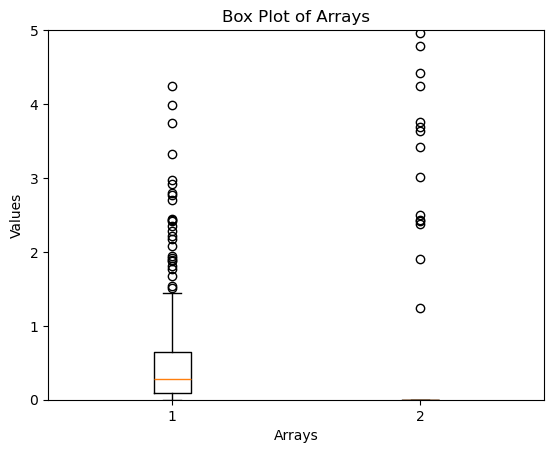

In [85]:
def plot_metmorphic_results(models):
    data = []
    for model in models:
        data.append([tup[1]*100 for tup in model.column_avg])
    
    plt.boxplot(data)
    # Add title and labels
    plt.title('Box Plot of Arrays')
    plt.xlabel('Arrays')
    plt.ylabel('Values')
    plt.ylim(0, 5)

    # Show the plot
    plt.show()
models = [model_1, gboost]
plot_metmorphic_results(models)


## Setting up a class to do mutation testing

In [57]:
class MutationTester:
    def __init__(self, data_path, model_path):
        self.model = model_path
        self.df = pd.read_csv(data_path)
    
    """
    The given training data is shuffled in a random order. Specifically, a random data point is swapped with another, 
    this is done equal to the iterations parameter number of times 
    """
    def data_shuffler(self, iterations=1000):
        shuffled_data = self.df.copy()
        num_rows = len(self.df)
        
        for i in range(iterations):
            # Choose two random indices for swapping
            idx1, idx2 = np.random.randint(0, num_rows, 2)
    
            # Swap rows at random two indices
            shuffled_data.iloc[idx1], shuffled_data.iloc[idx2] = (
                shuffled_data.iloc[idx2].copy(),
                shuffled_data.iloc[idx1].copy(),
            )
        return shuffled_data

    """
    A fixed percentage of the training data is removed (at random)
    """
    def data_remover(self, percent=0.1):
        # Calculate the number of rows to remove based on the percentage
        num_rows_to_remove = int(len(self.df) * percent)
        smaller_df = self.df.copy()
        return smaller_df.drop(smaller_df.sample(n=num_rows_to_remove).index)
    
    """
    Chosen randomly, the values of a row of the training data is replicated into another row. This is done
    iterations number of times
    """
    def data_repetition(self, iterations=1000):
        repeated_data = self.df.copy()
        num_rows = len(self.df)
        
        for i in range(iterations):
            # Choose two random indices. The value of the first will be duplicated onto the 2nd
            idx1, idx2 = np.random.randint(0, num_rows, 2)
            repeated_data.iloc[idx2] = repeated_data.iloc[idx1].values
        return repeated_data
    
    def label_error(self, num_rows):
        assert num_rows < len(self.df), "Please chose to alter the labels of less training data"
        changed_data = self.df.copy()
        # Get the indices of rows that will have their labels changed
        rows_to_change = np.random.choice(self.df.index, num_rows, replace=False)
        
        # Change the values of the last column ("checked") for the randomly selected rows (0 becomes 1 and vice versa)
        changed_data.loc[rows_to_change, self.df.columns[-1]] = 1 - changed_data.loc[rows_to_change, self.df.columns[-1]]
        
        return changed_data